In [17]:
#install required R packages 
suppressMessages(install.packages("BiocManager"))
suppressMessages(BiocManager::install(c('tximport','edgeR','variancePartition','BiocParallel','pheatmap', 'googleCloudStorageR', 'AnVIL')))


The downloaded binary packages are in
	/var/folders/c3/cr8rqqls3gn0r7h2cq16rxg80000gp/T//RtmpyZF7L4/downloaded_packages


Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'tximport' 'edgeR' 'variancePartition'
  'BiocParallel' 'pheatmap' 'googleCloudStorageR'”



The downloaded binary packages are in
	/var/folders/c3/cr8rqqls3gn0r7h2cq16rxg80000gp/T//RtmpyZF7L4/downloaded_packages


In [23]:
#set working directory

setwd("/Users/swekhand/Documents/GitHub/gro-crispri-ctcf/")
getwd()

[1] "/Users/swekhand/Documents/GitHub/gro-crispri-ctcf"

In [24]:
suppressMessages(library('tximport'))
suppressMessages(library('edgeR'))
suppressMessages(library('variancePartition'))
suppressMessages(library('BiocParallel'))
suppressMessages(library('pheatmap'))
suppressMessages(library('googleCloudStorageR'))
suppressMessages(library('AnVIL'))
options(googleAuthR.verbose = 2)
dir.create("rnaseq/")
setwd("rnaseq/")


In [25]:
#get required h5 matrices filepaths

filelist = read.csv("https://raw.githubusercontent.com/broadinstitute/gro-crispri-ctcf/dev/data/sg4_rnaseq_filepaths.txt?token=GHSAT0AAAAAACBUGAZUFHCLXGC32VUMN2TMZC6QVQQ", col.names = c("files") )
filelist

files
<chr>
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR83.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR97.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR87.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR86.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR95.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR96.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR84.h5
gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR85.h5


In [27]:
#download required h5 matrices

src = "gs://sw-gro-crispri-ctcf/rnaseq/sg4"
#gsutil_requesterpays(src)
gsutil_cp(source = src, destination = ".", recursive = T)

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/transcripts_to_genes.txt...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR82.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR83.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR84.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR85.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR86.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR87.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR95.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR96.h5...
Copying gs://sw-gro-crispri-ctcf/rnaseq/sg4/MR97.h5...


In [28]:
#set up design matrix and transcripts-to-gene dataframe

setwd("sg4/")
design_df = read.csv("https://raw.githubusercontent.com/broadinstitute/gro-crispri-ctcf/dev/data/sg4_rnaseq.tsv?token=GHSAT0AAAAAACBUGAZVTFGTV2NFL7KSFQD6ZC6QUUQ", sep = "\t")
rownames(design_df) = stringr::str_split_fixed(design_df$file, ".h5",2)[,1]
design_df$sample = rownames(design_df)
design_df$condition = as.factor(design_df$condition)
design_df$condition = relevel(design_df$condition, ref = "Safe-Harbor")
names(design_df) = c("path", "condition", "rep", "exp_day", "sample")

t2g = read.table("transcripts_to_genes.txt", stringsAsFactors = F, header=F, sep = "\t")
colnames(t2g) = c("target_id", "ens_gene", "gene_id")
t2g = t2g[,c("target_id","gene_id")]

design_df

,path,condition,rep,exp_day,sample
,<chr>,<fct>,<chr>,<int>,<chr>
MR82,MR82.h5,Safe-Harbor,rep1,1,MR82
MR83,MR83.h5,Safe-Harbor,rep2,1,MR83
MR97,MR97.h5,Safe-Harbor,rep1,2,MR97
MR87,MR87.h5,10-mer,rep4,1,MR87
MR86,MR86.h5,10-mer,rep3,2,MR86
MR95,MR95.h5,10-mer,rep1,2,MR95
MR96,MR96.h5,10-mer,rep2,2,MR96
MR84,MR84.h5,13-mer,rep1,1,MR84
MR85,MR85.h5,13-mer,rep2,1,MR85


In [36]:
#load h5 matrices 

source("https://raw.githubusercontent.com/mikelove/tximport/devel/R/helper.R")
files = paste0(rownames(design_df),".h5")
names(files) = rownames(design_df)
txi <- tximport(files, type="kallisto", tx2gene=t2g, geneIdCol = "gene_name", importer=read_kallisto_h5)


Note: importing `abundance.h5` is typically faster than `abundance.tsv`

1 
2 
3 
4 
5 
6 
7 
8 
9 


transcripts missing from tx2gene: 17686

summarizing abundance

summarizing counts

summarizing length



In [37]:
#set up count matrix, filter, and normalize

x = txi$counts
isexpr = rowSums(cpm(x)>0) >= nrow(design_df)
sum(isexpr)
y = DGEList(counts = x[isexpr,])
y = calcNormFactors( y )

[1] 16519

In [38]:
#set up threading parameters

param = SnowParam(6, "SOCK", progressbar=TRUE)

Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:292 s



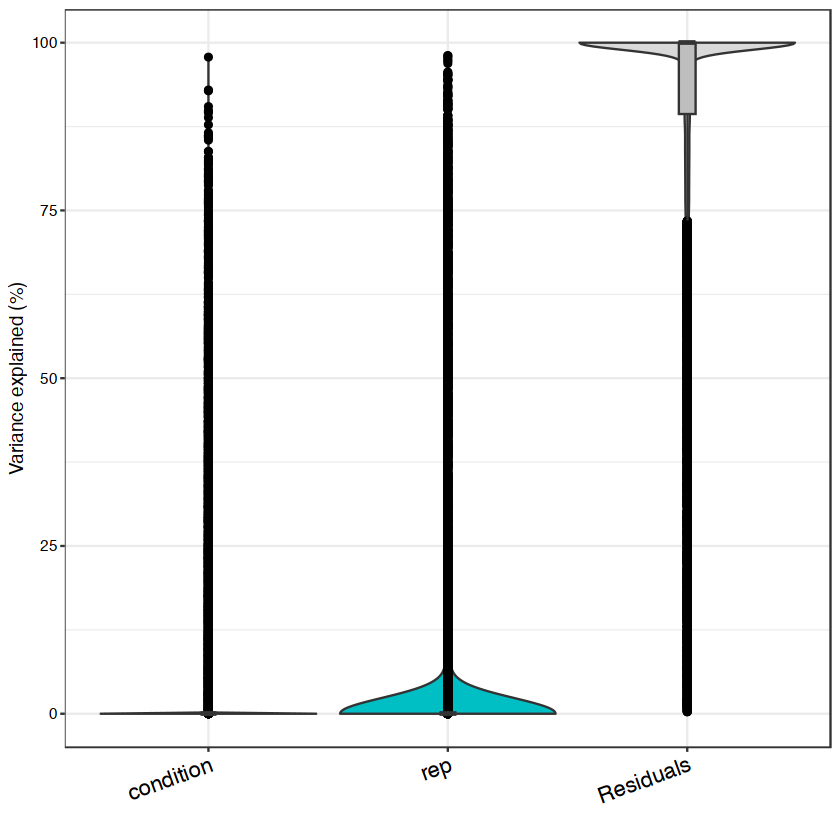

In [39]:
#run variancePartition model

varPart <- fitExtractVarPartModel( cpm(y), ~ (1|condition) + (1|rep), design_df, BPPARAM=param )
vp <- sortCols( varPart )
plotVarPart( vp )

In [40]:
#run voom with dream weights model

form <- ~ condition + (1|rep) 
vobjDream = voomWithDreamWeights( cpm(y), form, design_df, BPPARAM=param )


Memory usage to store result: >21.8 Mb

Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:274 s



In [41]:
#run dream model

fitmm = dream( vobjDream, form, design_df, BPPARAM=param )


Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:1523 s



In [42]:
#run eBayes model 

fitmm = eBayes(fitmm)

In [ ]:
##Uncomment if you would like to save the fitmm object

#saveRDS(fitmm,"~/fitmm_sg4_rnaseq.rds")
#fitmm = readRDS("~/fitmm_sg4_rnaseq.rds")

In [43]:
#display top 10 significant results between 10mer and Safe Harbor 

topTable( fitmm, coef='condition10-mer', number = 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008878.3,-1.3527690,4.326969,-11.225149,4.536949e-29,7.494586e-25,-3.301535,-11.190534
GIMAP1-GIMAP5,-1.7631404,2.225433,-8.395339,6.774555e-17,5.595444e-13,-3.923655,-8.350899
AC119396.1,-1.1509043,3.653704,-7.817394,5.938726e-15,3.270061e-11,-2.895026,-7.805242
SHANK3,-0.8981061,3.306056,-6.799591,1.170920e-11,3.678993e-08,-3.845687,-6.783755
CSRNP1,-0.7279872,3.954851,-6.780764,1.277752e-11,3.678993e-08,-3.675263,-6.771136
AURKA,-0.5032757,6.498759,-6.767191,1.336277e-11,3.678993e-08,-2.945169,-6.764655
MTND1P23,-1.2583411,2.634319,-6.187734,6.883674e-10,1.624449e-06,-4.008308,-6.168739
AC073896.1,-0.9762688,2.347627,-6.001088,2.191987e-09,4.526178e-06,-4.029421,-5.982901
AL136295.5,-0.8057195,1.927109,-5.328268,1.069988e-07,1.963903e-04,-4.032410,-5.314418


In [44]:
#extract significant results between 10mer and Safe Harbor 

var_df_res = as.data.frame(topTable( fitmm, coef='condition10-mer', number = Inf))
var_df_res[which((abs(var_df_res$logFC) > 1) & (abs(var_df_res$z.std) > 3)),]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008878.3,-1.352769,4.3269689,-11.225149,4.536949e-29,7.494586e-25,-3.301535,-11.190534
GIMAP1-GIMAP5,-1.763140,2.2254331,-8.395339,6.774555e-17,5.595444e-13,-3.923655,-8.350899
AC119396.1,-1.150904,3.6537045,-7.817394,5.938726e-15,3.270061e-11,-2.895026,-7.805242
MTND1P23,-1.258341,2.6343188,-6.187734,6.883674e-10,1.624449e-06,-4.008308,-6.168739
AC010970.1,1.006414,9.6139494,4.507429,6.575111e-06,5.430713e-03,-2.520756,4.506998
SMIM11B,-1.689789,1.7469662,-4.240921,2.263080e-05,1.246127e-02,-3.726214,-4.237216
COL12A1,1.261095,0.7613171,3.854512,1.172533e-04,3.797857e-02,-3.736953,3.851799
AC005943.1,-1.307659,1.0638280,-3.353926,8.065623e-04,1.268915e-01,-4.152977,-3.350533
NNAT,-1.207087,0.8264457,-3.117378,1.839184e-03,1.808422e-01,-4.173994,-3.115043


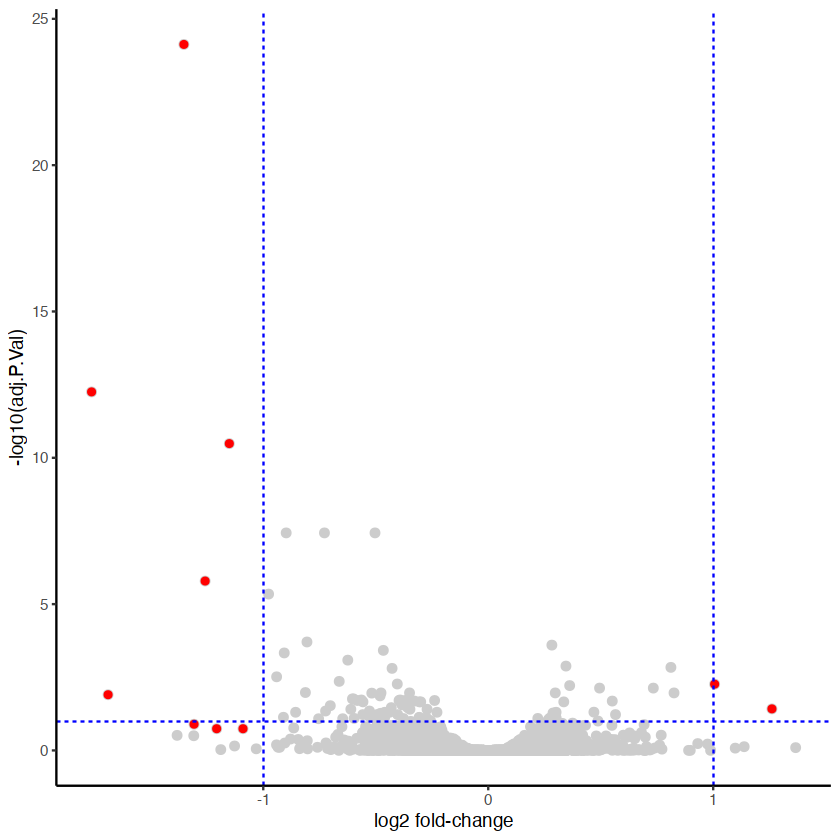

In [45]:
#volcano plot

ggplot(data= var_df_res, aes(x= logFC, y= -log10(adj.P.Val))) +
     geom_point(colour= 'grey80', size = 2) +
     geom_point(data= var_df_res[which((abs(var_df_res$logFC) > 1) & (abs(var_df_res$z.std) > 3)),], colour= 'red') +
     geom_vline(xintercept= c(-1, 1), colour= 'blue', linetype= 'dashed') +
     geom_hline(yintercept= 1, colour= 'blue', linetype= 'dashed') +
     #geom_point(data= , colour= 'orange')
     xlab('log2 fold-change') +
     ylab('-log10(adj.P.Val)') +
     theme_classic()

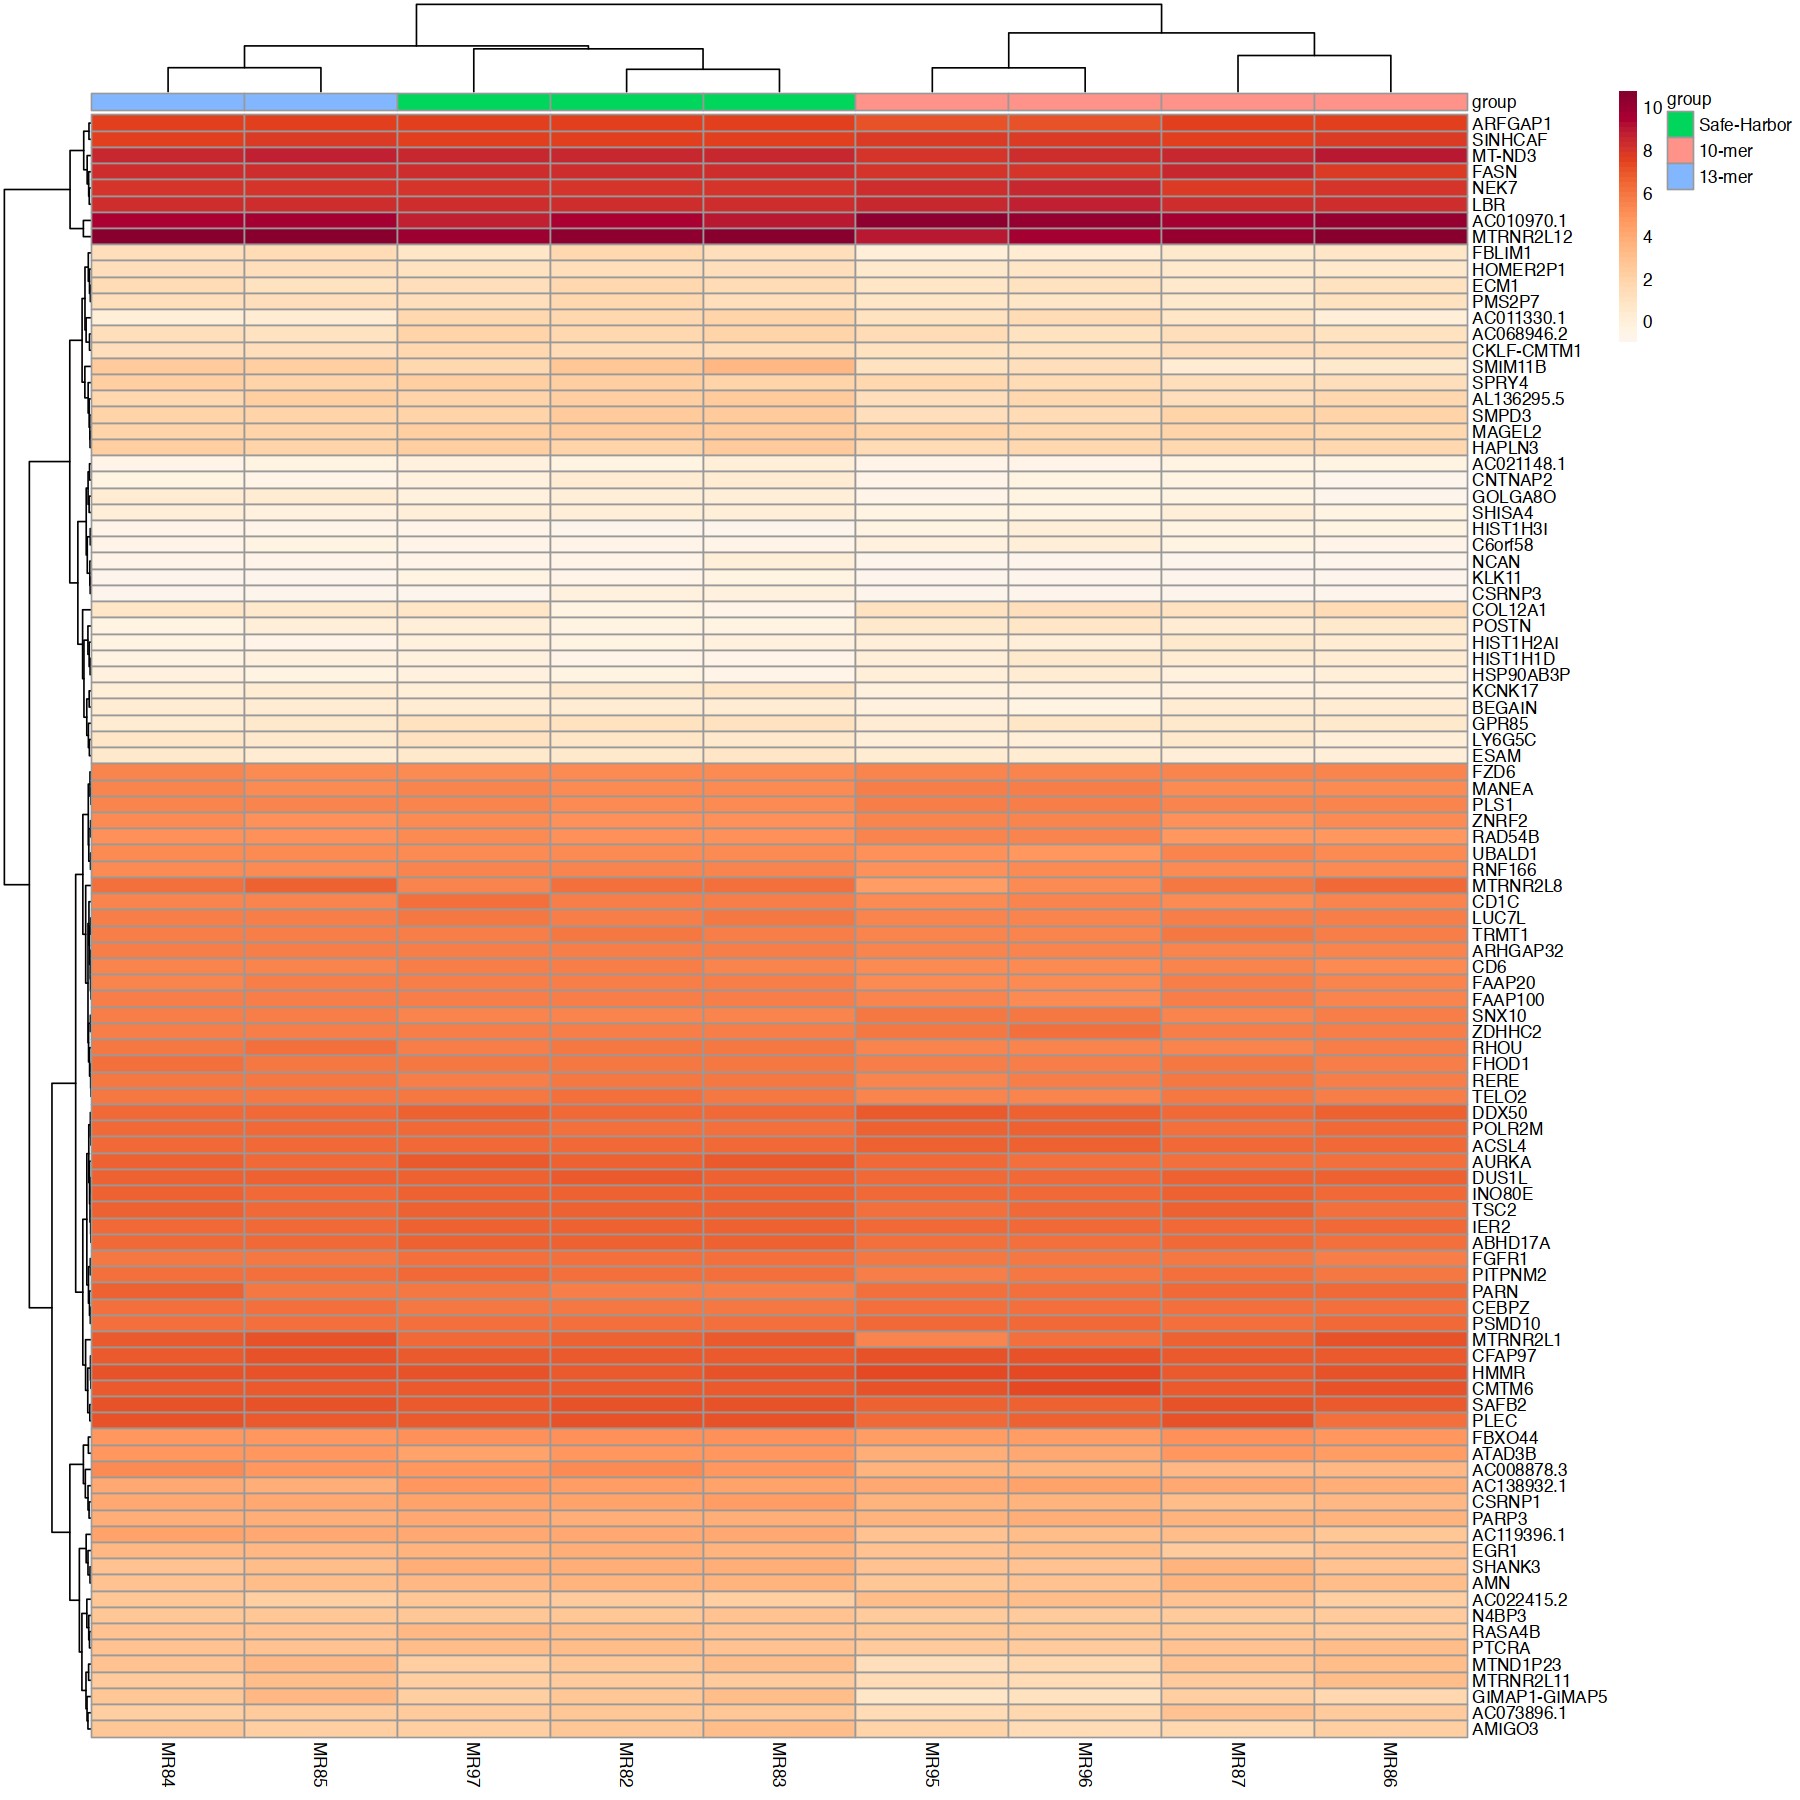

In [46]:
#heatmap of normalized counts of top DE 100 genes 

options(repr.plot.width=15, repr.plot.height=15)

anncol = data.frame(group = design_df$condition)
rownames(anncol) <- rownames(design_df)
pheatmap(mat = vobjDream$E[rownames(topTable( fitmm, coef='condition10-mer', number = 100)),], 
         cluster_cols = T, annotation_col = anncol,  color = hcl.colors(50, "OrRd", rev = T))